In [6]:
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set whitegrid style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

In [7]:
# =====================================================================================
# Please adjust the path to point to your results.json file for evaluation analysis
# =====================================================================================
# Load the results.json file
results_path = Path('../runs/20250528_113033-35f94652/results.json') # <- Adjust this path as needed

# Check if the file exists
if not results_path.exists():
    print(f"Error: File not found at {results_path}")
else:
    # Load the JSON data
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    # Convert to DataFrame for easier analysis
    if isinstance(results, list):
        df = pd.DataFrame(results)
        
        # Display basic information
        print(f"Number of records: {len(df)}")
        print("\nDataFrame columns:")
        print(df.columns.tolist())
        
        # Display summary statistics
        print("\nSummary statistics:")
        print(df.describe())
        
        # Display the first few rows
        print("\nSample data:")
        display(df.head())
        
        # Plot distributions of numerical columns (adjust as needed based on actual data)
        numeric_cols = df.select_dtypes(include=['number']).columns
        if len(numeric_cols) > 0:
            plt.figure(figsize=(15, 10))
            for i, col in enumerate(numeric_cols[:5]):  # Limit to first 5 numeric columns
                plt.subplot(2, 3, i+1)
                sns.histplot(df[col], kde=True)
                plt.title(f'Distribution of {col}')
            plt.tight_layout()
            plt.show()
    else:
        # If it's not a list, display the structure
        print("Results structure:")
        print(type(results))
        print(json.dumps(results, indent=2)[:500] + "..." if len(json.dumps(results)) > 500 else json.dumps(results, indent=2))

Results structure:
<class 'dict'>
{
  "status": "completed",
  "processed_count": 300,
  "failed_count": 0,
  "processed_samples": [
    {
      "sample_id": "sample_0000",
      "input": {
        "sample_id": "sample_0000",
        "image_path": "data\\vqarad_hf\\images\\sample_0000.png",
        "question": "are regions of the brain infarcted?",
        "answer": "yes",
        "question_type": "yes_no",
        "modality": "unknown",
        "metadata": {
          "original_index": 0,
          "image_name": "",
          "...


Overall Statistics:
status: completed
processed_count: 300
failed_count: 0

Processed Samples Statistics:
Number of processed samples: 300

Columns in processed samples:
['sample_id', 'input', 'output', 'status']

Question Type Distribution:
yes_no                   166
single_word               40
organ_identification      29
short_phrase              26
modality                  19
abnormality_detection     12
long_answer                5
counting                   3
Name: count, dtype: int64


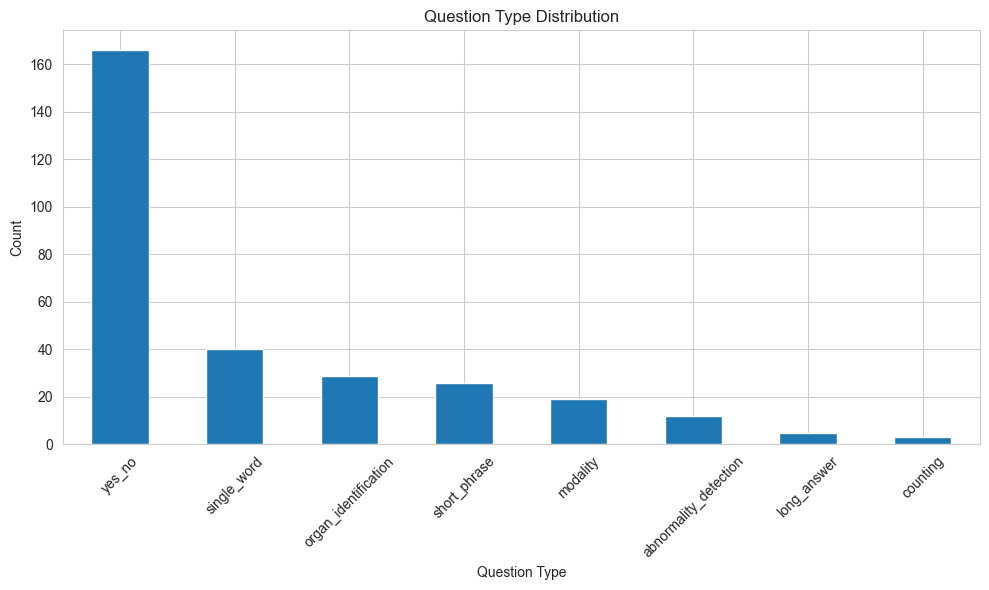

In [8]:
# Extract overall statistics
overall_stats = {
    'status': results['status'],
    'processed_count': results['processed_count'],
    'failed_count': results['failed_count']
}

print("Overall Statistics:")
for key, value in overall_stats.items():
    print(f"{key}: {value}")

# Create a DataFrame from the processed samples for detailed analysis
processed_df = pd.DataFrame(results['processed_samples'])

print("\nProcessed Samples Statistics:")
print(f"Number of processed samples: {len(processed_df)}")

# Check what columns are available in the processed samples
print("\nColumns in processed samples:")
print(processed_df.columns.tolist())

# Analyze question types if available
if 'input' in processed_df.columns:
    # Extract question_type from input dictionary
    question_types = [sample['input'].get('question_type', 'unknown') 
                     for sample in results['processed_samples']]
    
    question_type_counts = pd.Series(question_types).value_counts()
    
    print("\nQuestion Type Distribution:")
    print(question_type_counts)
    
    # Visualize question type distribution
    plt.figure(figsize=(10, 6))
    question_type_counts.plot(kind='bar')
    plt.title('Question Type Distribution')
    plt.ylabel('Count')
    plt.xlabel('Question Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# If there are evaluation metrics or scores in the processed samples, analyze them
if 'metrics' in processed_df.columns:
    print("\nEvaluation Metrics Summary:")
    metrics_df = pd.json_normalize([sample['metrics'] for sample in results['processed_samples'] if 'metrics' in sample])
    print(metrics_df.describe())
    
    # Plot distribution of primary metrics if they exist
    if not metrics_df.empty and len(metrics_df.columns) > 0:
        plt.figure(figsize=(12, 8))
        for i, col in enumerate(metrics_df.columns[:4]):  # Limit to first 4 metrics
            plt.subplot(2, 2, i+1)
            sns.histplot(metrics_df[col], kde=True)
            plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()

Statistics by Question Type:
                       count  needs_review_percent  uncertainty  \
question_type                                                     
abnormality_detection     12                 100.0     0.840000   
counting                   3                 100.0     0.866667   
long_answer                5                 100.0     0.850000   
modality                  19                 100.0     0.957895   
organ_identification      29                 100.0     0.882759   
short_phrase              26                 100.0     0.794231   
single_word               40                 100.0     0.868750   
yes_no                   166                 100.0     0.891867   

                       overall_quality  speech_quality  visual_quality  \
question_type                                                            
abnormality_detection         0.553333        0.683333        0.941667   
counting                      0.416667        0.782000        0.916667   
long

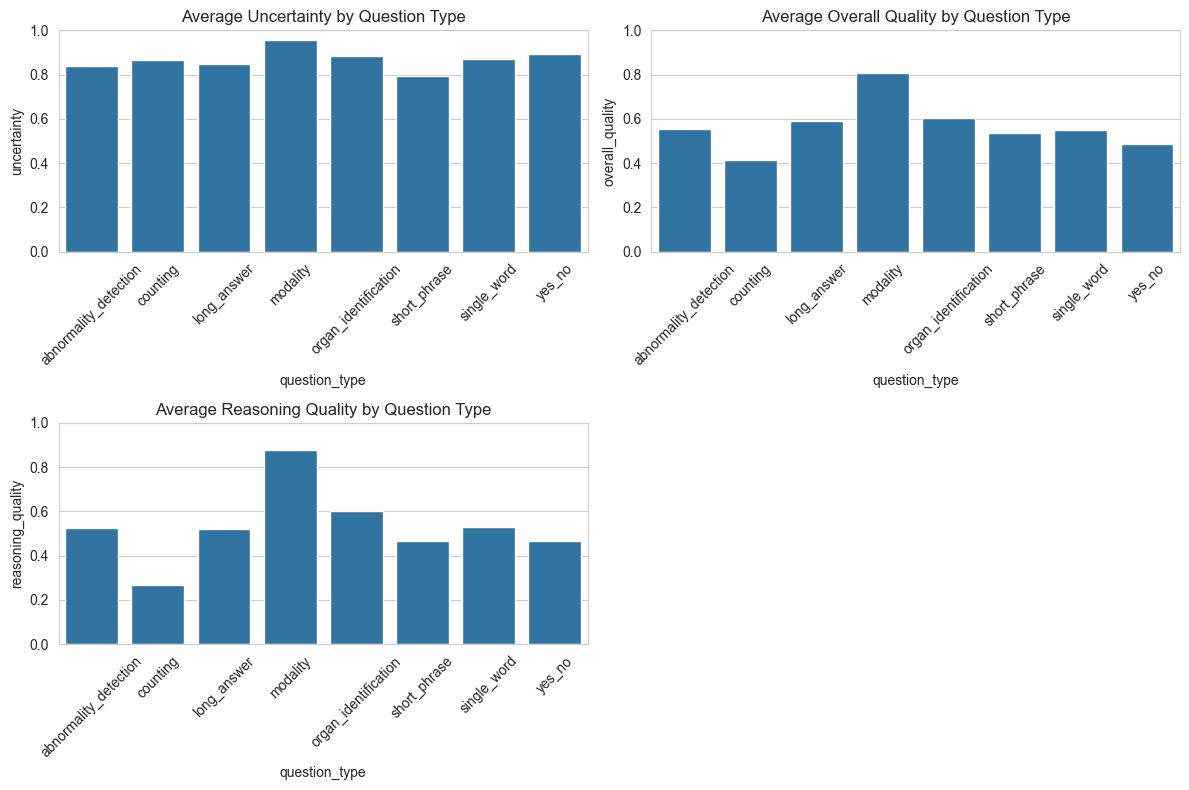


Samples Needing Review: 300 (100.00%)


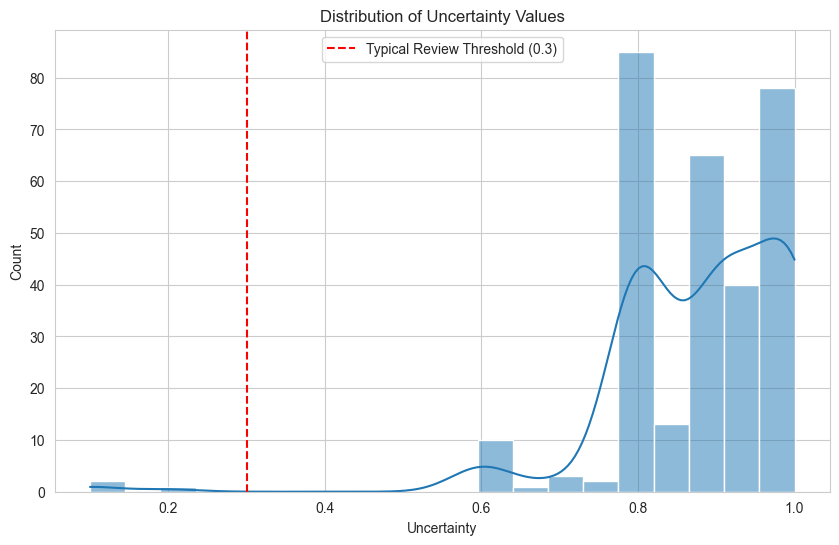

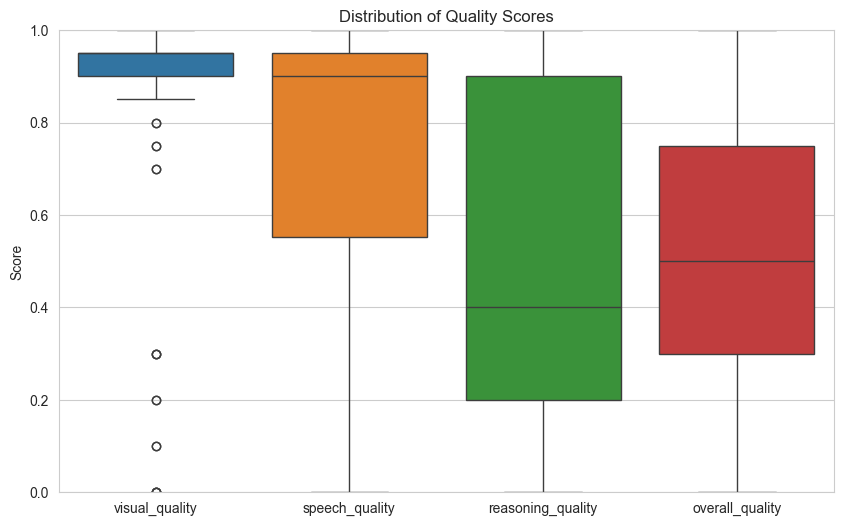

In [9]:
# Extract input and output details into separate columns
processed_df['question'] = processed_df['input'].apply(lambda x: x.get('question', '') if isinstance(x, dict) else '')
processed_df['ground_truth'] = processed_df['input'].apply(lambda x: x.get('answer', '') if isinstance(x, dict) else '')
processed_df['question_type'] = processed_df['input'].apply(lambda x: x.get('question_type', 'unknown') if isinstance(x, dict) else 'unknown')
processed_df['modality'] = processed_df['input'].apply(lambda x: x.get('modality', 'unknown') if isinstance(x, dict) else 'unknown')

# Extract quality scores
processed_df['uncertainty'] = processed_df['output'].apply(lambda x: x.get('uncertainty', None) if isinstance(x, dict) else None)
processed_df['needs_review'] = processed_df['output'].apply(lambda x: x.get('needs_review', None) if isinstance(x, dict) else None)

# Extract all quality scores if available
processed_df['visual_quality'] = processed_df['output'].apply(
    lambda x: x.get('quality_scores', {}).get('visual_localization_quality', None) if isinstance(x, dict) else None)
processed_df['speech_quality'] = processed_df['output'].apply(
    lambda x: x.get('quality_scores', {}).get('speech_processing_quality', None) if isinstance(x, dict) else None)
processed_df['reasoning_quality'] = processed_df['output'].apply(
    lambda x: x.get('quality_scores', {}).get('reasoning_quality', None) if isinstance(x, dict) else None)
processed_df['overall_quality'] = processed_df['output'].apply(
    lambda x: x.get('quality_scores', {}).get('overall_quality', None) if isinstance(x, dict) else None)

# Display statistics by question type
print("Statistics by Question Type:")
question_type_stats = processed_df.groupby('question_type').agg({
    'sample_id': 'count',
    'needs_review': lambda x: (x == True).mean() * 100,
    'uncertainty': 'mean',
    'overall_quality': 'mean',
    'speech_quality': 'mean',
    'visual_quality': 'mean',
    'reasoning_quality': 'mean',
}).rename(columns={
    'sample_id': 'count',
    'needs_review': 'needs_review_percent',
})

print(question_type_stats)

# Visualize quality metrics by question type
plt.figure(figsize=(12, 8))
metrics = ['uncertainty', 'overall_quality', 'reasoning_quality']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=question_type_stats.index, y=question_type_stats[metric])
    plt.title(f'Average {metric.replace("_", " ").title()} by Question Type')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Calculate samples needing review
needs_review_count = processed_df['needs_review'].sum()
needs_review_percent = (needs_review_count / len(processed_df)) * 100

print(f"\nSamples Needing Review: {needs_review_count} ({needs_review_percent:.2f}%)")

# Histogram of uncertainty values
plt.figure(figsize=(10, 6))
sns.histplot(processed_df['uncertainty'], bins=20, kde=True)
plt.title('Distribution of Uncertainty Values')
plt.xlabel('Uncertainty')
plt.ylabel('Count')
plt.axvline(x=0.3, color='red', linestyle='--', label='Typical Review Threshold (0.3)')
plt.legend()
plt.show()

# Box plot of quality scores
quality_scores = processed_df[['visual_quality', 'speech_quality', 'reasoning_quality', 'overall_quality']]
plt.figure(figsize=(10, 6))
sns.boxplot(data=quality_scores)
plt.title('Distribution of Quality Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

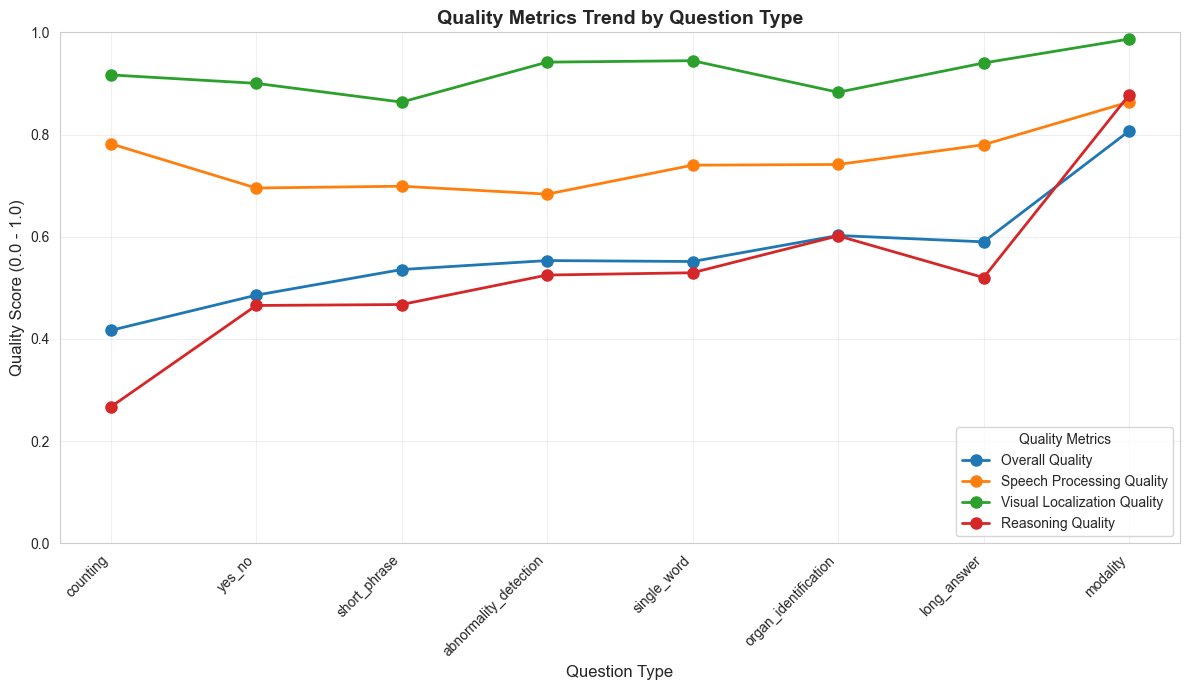


Quality Metrics Summary by Question Type (sorted by avg score):
                       visual_quality  speech_quality  reasoning_quality  \
question_type                                                              
counting                        0.917           0.782              0.267   
yes_no                          0.900           0.695              0.465   
short_phrase                    0.863           0.699              0.467   
abnormality_detection           0.942           0.683              0.525   
single_word                     0.944           0.740              0.530   
organ_identification            0.883           0.741              0.602   
long_answer                     0.940           0.780              0.520   
modality                        0.987           0.864              0.877   

                       overall_quality  
question_type                           
counting                         0.417  
yes_no                           0.486  
short_phra

In [11]:
# Quality Metrics Trend by Question Type
# Create a line plot showing different quality metrics across question types

# Calculate mean quality scores by question type
quality_metrics = processed_df.groupby('question_type').agg({
    'visual_quality': 'mean',
    'speech_quality': 'mean',
    'reasoning_quality': 'mean',
    'overall_quality': 'mean'
})

# Sort by average score across all metrics (low to high)
quality_metrics['avg_score'] = quality_metrics.mean(axis=1)
quality_metrics = quality_metrics.sort_values('avg_score')
quality_metrics = quality_metrics.drop(columns=['avg_score'])

# Create the line plot
plt.figure(figsize=(12, 7))

# Plot each quality metric as a line (using actual metric names)
plt.plot(quality_metrics.index, quality_metrics['overall_quality'], 'o-', 
         color='#1f77b4', linewidth=2, markersize=8, label='Overall Quality')
plt.plot(quality_metrics.index, quality_metrics['speech_quality'], 'o-', 
         color='#ff7f0e', linewidth=2, markersize=8, label='Speech Processing Quality')
plt.plot(quality_metrics.index, quality_metrics['visual_quality'], 'o-', 
         color='#2ca02c', linewidth=2, markersize=8, label='Visual Localization Quality')
plt.plot(quality_metrics.index, quality_metrics['reasoning_quality'], 'o-', 
         color='#d62728', linewidth=2, markersize=8, label='Reasoning Quality')

plt.title('Quality Metrics Trend by Question Type', fontsize=14, fontweight='bold')
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Quality Score (0.0 - 1.0)', fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Quality Metrics', loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nQuality Metrics Summary by Question Type (sorted by avg score):")
print(quality_metrics.round(3))